# Tahakom Training Week 3: Beyond-supervised-training
##  Day1: Self-Supervised Learning with Rotation Prediction

Today, we will explore the concepts of self-supervised learning using Rotation Prediction task.  During this practical session we will set up the development environment, implement its framework, pretraining and evaluation.




# Task Description: Rotation Prediction
## Background
Self-Supervised Learning (SSL) is a technique that leverages the inherent structure in data to learn useful representations without the need for large amounts of labeled data. In computer vision tasks, SSL uses pretext tasks to train models, enabling them to extract meaningful information from unlabeled data. This approach is particularly valuable in visual tasks as it improves the model’s generalization ability for downstream tasks. 
Rotation prediction is a widely used pretext task in SSL, first introduced by Gidaris et al. in 2018. The core idea behind this task is to take an image, apply random rotations (e.g., 0°, 90°, 180°, and 270°), and require the model to predict the rotation angle. This forces the model to learn the semantic information and geometric structure of the objects in the image, resulting in more effective visual feature learning.
Framework of [Rotation Prediction](https://arxiv.org/abs/1803.07728) is visualized below.

<center width="100%"><img src="./rotnet.png" width="500px"></center>


## Task Definition
In this assignment, we will use the rotation prediction task as a pre-training objective in a self-supervised learning framework. Specifically, we will apply four possible rotation transformations to the input images:

0°: No rotation, the image remains unchanged.

90°: Rotate the image 90 degrees clockwise.

180°: Rotate the image 180 degrees clockwise.

270°: Rotate the image 270 degrees clockwise.

The goal is to design a model that takes in the rotated image and predicts the corresponding rotation angle class (0, 90, 180, or 270).

## Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
import torch

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:11<00:00, 14658541.75it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Visualization
Show some example images with labels:

In [6]:
class Denormalize(object):
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(3, 1, 1)
        self.std = torch.tensor(std).view(3, 1, 1)

    def __call__(self, tensor):
        return tensor * self.std + self.mean

mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

denormalize = Denormalize(mean, std)


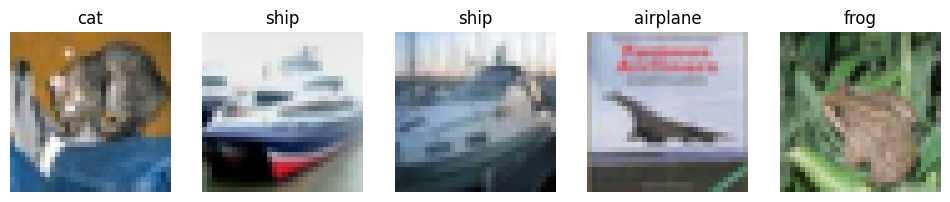

In [7]:
num_images = 5
images, labels = zip(*[(test_dataset[i][0], test_dataset[i][1]) for i in range(num_images)])

def show_tensor_images(images, labels, classes):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 3))
    for i, image in enumerate(images):
        image = denormalize(image)
        image = image.permute(1, 2, 0).numpy()  
        image = np.clip(image * 255, 0, 255).astype(np.uint8)
        axes[i].imshow(image)
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.show()

show_tensor_images(images, labels, test_dataset.classes)

## Data Loading
For this task, the CIFAR-100 dataset will be loaded and prepared using deep learning frameworks such as PyTorch. The images will be normalized, and during preprocessing, we will apply rotations of 0°, 90°, 180°, and 270° to create the data required for the rotation prediction task. Write the data loading function to return the necessary rotated images.

In [9]:
import random
import torch

def rotate_image(image, rotation):
    if rotation == 90:
        return torch.rot90(image, 1, [1, 2])
    elif rotation == 180:
        return torch.rot90(image, 2, [1, 2])
    elif rotation == 270:
        return torch.rot90(image, 3, [1, 2])
    else:
        return image

class RotationPredictionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, seed=None):
        self.dataset = dataset
        self.rotations = [0, 90, 180, 270]
        self.labels = {0: 0, 90: 1, 180: 2, 270: 3}
        if seed is not None:
            random.seed(seed) 

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        
        #  Write the data set function return rotated image required for the SSL task
        #your implementation goes here

        return

## Visualization
Show some rotated images with labels:

In [10]:
def visualize_rotation_dataset(dataset, num_images=5):
    images, labels = zip(*[dataset[i] for i in range(num_images)])

    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
    for i, image in enumerate(images):
        image = denormalize(image)
        image = image.permute(1, 2, 0).numpy()  
        image = np.clip(image * 255, 0, 255).astype(np.uint8)  
        axes[i].imshow(image)
        axes[i].set_title(f"Rotation: {labels[i] * 90}°")  
        axes[i].axis('off')
    plt.show()

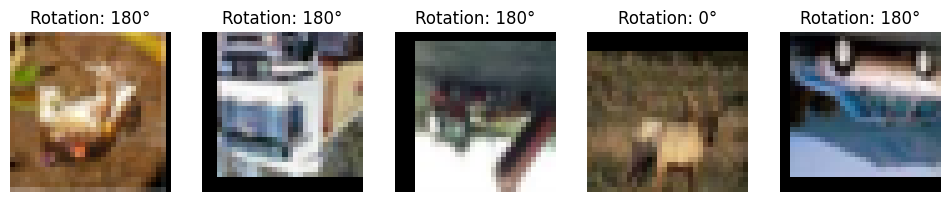

In [11]:
pretrain_dataset = RotationPredictionDataset(train_dataset)
visualize_rotation_dataset(pretrain_dataset)
pretrain_test_dataset = RotationPredictionDataset(test_dataset)

## Training code

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def eval(model, model_path, dataset, batch_size, device):
    model.load_state_dict(torch.load(model_path))
    model.eval()

    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def train_model(model, train_loader, loss_fn, optimizer, epochs, save_path, device, init_lr, decay_epochs):
    model.train()  
    best_loss = float('inf')
    epoch_losses = []  
    
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_loss)  
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), save_path)
            print(f'Model is saved to {save_path}, Best Loss: {best_loss:.4f}')

    print("Training finished!")
    return epoch_losses

def plot_loss_curve(losses):
    plt.figure()
    plt.plot(range(1, len(losses) + 1), losses, marker='o')
    plt.title("Training Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

### Pretraining
For this practical session, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details. We will randomly initialize a ResNet18 model and pretrain on the rotation prediction task. Your task is to instantiate the correct the model and loss function required for the task of rotation prediction. You can directly use inbuilt pytorch modules for that. 



Training finished!


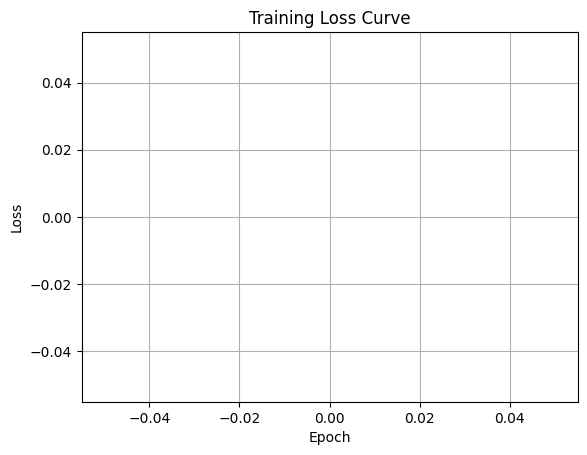

Test Accuracy: 24.77%


In [17]:

from torchvision.models import resnet18

model = None # To do, Create the required model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss_fn = # To do, Write your loss here


batch_size = 128
epochs = 0
learning_rate = 0.01
decay_epochs = 15
best_save_path = "./best_pretrained_model.pth"
last_save_path = "./last_pretrained_model.pth"
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(pretrain_dataset, batch_size=batch_size, shuffle=True)
epoch_losses = train_model(model, train_loader, loss_fn, optimizer, epochs, best_save_path, device, init_lr=learning_rate, decay_epochs=decay_epochs)

plot_loss_curve(epoch_losses)
torch.save(model.state_dict(), last_save_path)
eval(model, last_save_path, pretrain_dataset, batch_size, device)

## Evaluation
There are two way to evaluate features that we learn from self-supervised pertaining. 
(1) Finetuning: Initialize the model with the pretrained weights from SSL tasks and finetune the whole network  for the downstream task.
(2) Linear Classification: Initialize the model with the pretrained weights from SSL tasks and  freeze the backbone network and train a linear classifier only the for the downstream task. Next, we are going to implement both evaluations for the model that we trained above using SSL pretraining. 


## Finetuning
In this section, we will load the pretrained weight and fine-tune on the classification task.

In [ ]:
model = None
# your implementation goes here
# note that you have to load the weights from the model that we trained above and train all its layers for the task of classification


batch_size = 128
epochs = 20
learning_rate = 0.01
decay_epochs = 10
best_save_path = "./best_finetune_pretrained_model.pth"
last_save_path = "./last_finetune_pretrained_model.pth"

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epoch_losses = train_model(model, train_loader, loss_fn, optimizer, epochs, best_save_path, device, learning_rate, decay_epochs=decay_epochs)
plot_loss_curve(epoch_losses)
torch.save(model.state_dict(), last_save_path)
eval(model, last_save_path, test_dataset, batch_size, device)

## Linear evaluation
In this section, we will load the pretrained weight and train for the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [6]:
model = None
# your implementation goes here
# note that you have to freeze the backbone network layers except for the 'layer4' block and 'fc' layer.


batch_size = 128
epochs = 20
learning_rate = 0.01
decay_epochs = 10
best_save_path = "./best_linear_pretrained_model.pth"
last_save_path = "./last_linear_pretrained_model.pth"

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epoch_losses = train_model(model, train_loader, loss_fn, optimizer, epochs, best_save_path, device, learning_rate, decay_epochs=decay_epochs)
plot_loss_curve(epoch_losses)
torch.save(model.state_dict(), last_save_path)
eval(model, last_save_path, test_dataset, batch_size, device)

NameError: name 'DataLoader' is not defined

## Supervised training from scratch
In this section, we will randomly initialize a ResNet18 model and train it directly  on the target dataset for classification task. We can directly compare the performance with the finetuning above.

In [ ]:
model = resnet18(num_classes=10)
batch_size = 128
epochs = 20
learning_rate = 0.01
decay_epochs = 10
best_save_path = "./best_supervised_pretrained_model.pth"
last_save_path = "./last_supervised_pretrained_model.pth"

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epoch_losses = train_model(model, train_loader, loss_fn, optimizer, epochs, best_save_path, device, init_lr=learning_rate, decay_epochs=decay_epochs)
plot_loss_curve(epoch_losses)
torch.save(model.state_dict(), last_save_path)
eval(model, last_save_path, test_dataset, batch_size, device)